In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display # NOTE: will require ffmpeg installation
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import seaborn as sns
from xarrayutils.utils import linear_trend, xr_linregress
from eofs.xarray import Eof
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# Data file paths
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc' # Data containing regridded flux and SSH for 150 years
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson' # File contains all defined ice shelves
figures_folderpath = 'reports/figures/' # Folder for output figures

#W_Ross_1_filepath = 'data/interim/region.geojson'

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'

flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'

In [3]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh
lat = data.lat
lon = data.lon

In [ ]:
icems

In [4]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);
# Specify projection for data file flux array
flux.rio.write_crs("epsg:3031",inplace=True);

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(icems.name)

In [ ]:
for i in range(33,133):
    print('extracting data for catchment {}'.format(icems.name.values[i]))

In [ ]:
h = data.timeMonthly_avg_ssh
h_mean = h.mean('time')

In [ ]:
for i in range(39,44):
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    ds = data.rio.clip(icems.loc[[i],'geometry'].apply(mapping),icems.crs,drop=False)
    flx = ds.timeMonthly_avg_landIceFreshwaterFlux
    flx_mean = flx.mean('time')
    #h = ds.timeMonthly_avg_ssh
    #h_mean = h.mean('time')
    # Dedraft: Linear Regression with SSH over chosen basin
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    flx_rgrs = xr_linregress(h, flx_mean, dim='time') # h = independent variable
    flx_prd = flx_rgrs.slope*h_mean + flx_rgrs.intercept
    #flx_ddrft = flx - flx_prd
    flx_prd.to_netcdf(inDirName+interim_data_folder+flux_dedrafted_iceshelves_data_path+'{}_rgrs.nc'.format(icems.name.values[i]))
    print('{} file saved'.format(icems.name.values[i]))
    del ds, flx, flx_mean, flx_rgrs, flx_prd
    print('deleted interim variables')
    gc.collect()

In [ ]:
np_flux_array = np.empty(data.timeMonthly_avg_landIceFreshwaterFlux[0].shape)
np_flux_array[:] = np.nan

iceshelves_rgrs_array = xr.DataArray(np_flux_array, coords=data.timeMonthly_avg_landIceFreshwaterFlux[0].coords, dims = data.timeMonthly_avg_landIceFreshwaterFlux[0].dims, attrs=data.timeMonthly_avg_landIceFreshwaterFlux.attrs)
#iceshelves_rgrs = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(iceshelves_rgrs_array)), coords=data.coords, attrs=data.timeMonthly_avg_landIceFreshwaterFlux.attrs)
iceshelves_rgrs = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(iceshelves_rgrs_array)))

for i in range(33,133):
    iceshelves_rgrs_catchment = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_iceshelves_data_path+'{}_rgrs.nc'.format(icems.name.values[i]))
    iceshelves_rgrs_catchment['timeMonthly_avg_landIceFreshwaterFlux'] = iceshelves_rgrs_catchment['__xarray_dataarray_variable__']
    iceshelves_rgrs_catchment = iceshelves_rgrs_catchment.drop(['__xarray_dataarray_variable__'])
    iceshelves_rgrs = xr.merge([iceshelves_rgrs, iceshelves_rgrs_catchment], compat='no_conflicts')

In [ ]:
iceshelves_rgrs.timeMonthly_avg_landIceFreshwaterFlux.plot()

In [ ]:
for i in range(33,39):
    print('extracting data for catchment {}'.format(icems.name.values[i]))

In [ ]:
IMBIE1_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[6]))
IMBIE2_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[7]))
IMBIE3_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[8]))
IMBIE4_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[9]))
IMBIE5_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[10]))
IMBIE6_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[11]))
IMBIE7_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[12]))
IMBIE8_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[13]))
IMBIE9_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[14]))
IMBIE10_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[15]))
IMBIE11_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[16]))
IMBIE12_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[17]))
IMBIE13_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[18]))
IMBIE14_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[19]))
IMBIE15_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[20]))
IMBIE16_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[21]))
IMBIE17_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[22]))
IMBIE18_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[23]))
IMBIE19_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[24]))
IMBIE20_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[25]))
IMBIE21_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[26]))
IMBIE22_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[27]))
IMBIE23_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[28]))
IMBIE24_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[29]))
IMBIE25_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[30]))
IMBIE26_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[31]))
IMBIE27_dedrafted = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'{}_dedrafted.nc'.format(icems.name.values[32]))

In [ ]:
IMBIE_dedrafted_total = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_data_path+'IMBIE_dedrafted_total.nc')

In [ ]:
flux_dedraft = IMBIE_dedrafted_total.__xarray_dataarray_variable__
h = ssh

In [ ]:
flux_prd = iceshelves_rgrs.timeMonthly_avg_landIceFreshwaterFlux
h = ssh
flux_dedraft = flux - flux_prd

In [ ]:
iceshelves_rgrs.to_netcdf(inDirName+interim_data_folder+flux_dedrafted_iceshelves_data_path+'iceshelves_rgrs_total.nc')

In [ ]:
flux_dedraft.to_netcdf(inDirName+interim_data_folder+flux_dedrafted_iceshelves_data_path+'iceshelves_dedrafted_total.nc')

In [5]:
iceshelves_dedrafted_total = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_iceshelves_data_path+'iceshelves_dedrafted_total.nc')

In [6]:
flux_dedraft = iceshelves_dedrafted_total.timeMonthly_avg_landIceFreshwaterFlux
h = ssh

In [7]:
flux_dedraft_tmean = flux_dedraft.mean('time')

In [8]:
flux_dedraft_demeaned = flux_dedraft - flux_dedraft_tmean

In [ ]:
basin = 104
basinName = icems.name.values[basin]
ds = data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
# icems.geometry[104].geoms[3]

In [ ]:
flx = ds.timeMonthly_avg_landIceFreshwaterFlux
h = ds.timeMonthly_avg_ssh

In [ ]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
icems[6:33].boundary.plot(ax=ax1,linewidth=0.5)
#wross2.plot(ax=ax1)
#wross1.plot(ax=ax1)
#icems.geometry[104].plot(ax=ax1)

In [ ]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
icems[34:133].boundary.plot(ax=ax1,linewidth=0.5)
wross1.plot(ax=ax1)

In [ ]:
flxn = flx.dropna('time',how='all')
flxn = flxn.dropna('y',how='all')
flxn = flxn.dropna('x',how='all')

hn = h.dropna('time',how='all')
hn = hn.dropna('y',how='all')
hn = hn.dropna('x',how='all')

In [ ]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,6))

#ax.set(xlim=(-3, 3), ylim=(-1, 1))
scat = ax.scatter(flx[0,:,:], h[0,:,:])
 
def animate(i):
    scat.set_offsets(np.c_[flx[i,:,:].values.flatten(), h[i,:,:].values.flatten()])
    ax.set_title("time = " + str(flxn.coords['time'].values[i])[:7])

anim = animation.FuncAnimation(fig, animate, interval=100, frames=500)

In [ ]:
# View animation in browser / save to file
HTML(anim.to_jshtml())
# ani.save(inDirName+figures_folderpath+'AIS_flux.mp4')

In [ ]:
%%time
# Dedraft: Linear Regression with SSH over chosen basin
flux_regress = xr_linregress(hn, flxn.mean('time'),dim='time') # h = independent variable
flux_pred = flux_regress.slope*ssh.mean('time') + flux_regress.intercept
flux_dedraft = flxn - flux_pred

In [ ]:
# Plot catchments used
# Are these the best catchment definitions for this dataset? 
# Catchments to be defined so that the melt-rate depth relationship is well established

plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
icems[34:133].boundary.plot(ax=ax1,linewidth=0.5)
ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)

In [ ]:
############################## DEDRAFT ##############################
# To be done on a catchment-by-catchment basis, i.e., in a way such that the 
# meltrate-depth relationship is well constructed

In [ ]:
%%time
# Dedraft: Linear Regression with SSH
flux_regress = xr_linregress(ssh, flux.mean('time'),dim='time') # h = independent variable
flux_pred = flux_regress.slope*ssh.mean('time') + flux_regress.intercept
flux_dedraft = flux - flux_pred

In [9]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = flux_dedraft_demeaned.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [ ]:
# Linear trend, if any
def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

In [ ]:
%%time
# Remove linear trend from the deseasonalized anomalies
flux_clean = detrend_dim(flux_anm, 'time', 1)

In [ ]:
%%time
# Time series of intermediate preprocessing results above for plotting
#flux_orig_series = flux.sum(['y','x'])
#flux_pred_series = flux_pred.sum(['y','x'])
flux_dedraft_series = flux_dedraft_demeaned.sum(['y','x'])
flux_anm_series = flux_anm.sum(['y','x'])
#flux_clean_series = flux_clean.sum(['y','x'])
#flux_seasonal_series = flux_dedraft_series - flux_anm_series
#flux_linear_trend_series = flux_anm_series - flux_clean_series

In [ ]:
flux_seasonal_series = flux_dedraft_series - flux_anm_series

In [ ]:
# Plot time series
plt.figure(figsize=(25,8))
#flux_orig_series.plot()
flux_dedraft_series.plot()
flux_anm_series.plot()
#flux_seasonal_series.plot()
#flux_linear_trend_series.plot()
#flux_clean_series.plot()

In [ ]:
plt.figure(figsize=(25,8))
flux_orig_series.plot()
flux_reconstr_series = flux_anm_series+flux_seasonal_series+flux_pred.sum(['y','x'])
flux_reconstr_series.plot()

In [ ]:
# Seasonal and Linear Trend Decomposition

plt.subplots(3, figsize=(30, 18), dpi=80)
plt.suptitle('Seasonal and Linear Trend Decomposition')

plt.subplot(311)
flux_anm_series.plot(color='k', linewidth=2)
plt.title('Deseasonalized and Detrended Data')

plt.subplot(312)
flux_linear_trend_series.plot(color='r', linestyle='--', linewidth=0.95)
plt.ylabel('Linear Trend')
plt.title('')

plt.subplot(313)
flux_seasonal_series.plot(color='m', linestyle='dotted', linewidth=0.95)
plt.ylabel('Seasonal Cycle')
plt.title('')

In [10]:
# Convert to numpy array for use in Eof.standard interface
# Can be removed once bug in Eof.xarray interface is fixed
spinup_period_years = 20 # Check with LANL team on period of datapoints to be removed before PCA
spinup_time_period = 12*spinup_period_years

# Cut off initial 'model spinup period' data before analysis
#flux_clean_array = flux_clean[spinup_time_period:].to_numpy()

#flux_clean = flux_clean[spinup_time_period:]
flux_clean = flux_anm[spinup_time_period:]

In [11]:
%%time
# EOF/PCA analysis
# fluxsolver = Eof(flux_clean_array) # using eof.standard numpy interface
fluxsolver = Eof(flux_clean) # using eof.xarray interface

CPU times: user 2min 21s, sys: 55.9 s, total: 3min 17s
Wall time: 59.3 s


In [12]:
# Define EOFs and PCs
fluxeofs = fluxsolver.eofs()
fluxpcs = fluxsolver.pcs()

In [13]:
fluxrec = fluxsolver.reconstructedField(10)

In [14]:
flux_rec_ts = fluxrec.sum(['y','x'])
flux_clean_ts = flux_clean.sum(['y','x'])

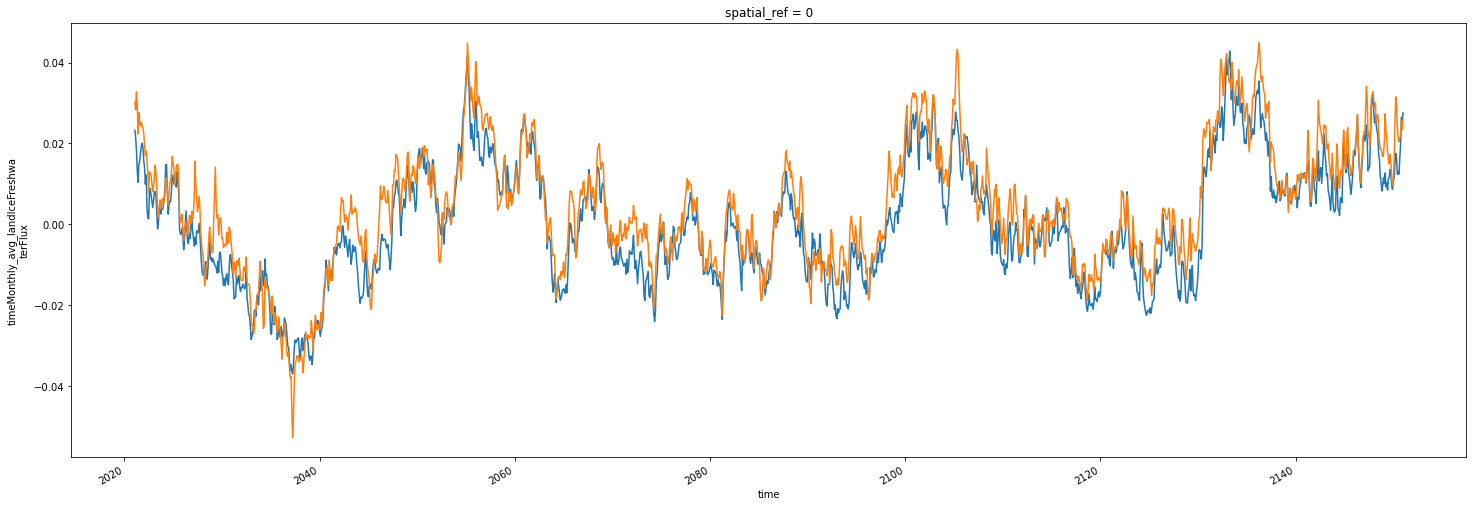

In [15]:
plt.figure(figsize=(25,8))
flux_rec_ts.plot()
flux_clean_ts.plot()

In [ ]:
plt.figure(figsize=(25,8))
plt.subplot(121)
flux_clean[1540].plot()
plt.subplot(122)
rec[1540].plot()

In [ ]:
#reconstr = fluxpcs*fluxeofs

In [ ]:
# Eigenvalues of the EOF analysis
# QUESTION: Are these the same as 'weights'?
fluxeigs = fluxsolver.eigenvalues()
fluxeigs_frac = fluxeigs*100/sum(fluxeigs) # Percentage of variability explained by each mode

In [ ]:
plt.plot(fluxeigs_frac[0:10],'*')

In [ ]:
reconstr0 = fluxeigs_frac[0]*fluxpcs[:,0]*fluxeofs[0,:,:]
reconstr1 = fluxeigs_frac[1]*fluxpcs[:,1]*fluxeofs[1,:,:]
reconstr2 = fluxeigs_frac[2]*fluxpcs[:,2]*fluxeofs[2,:,:]
reconstr3 = fluxeigs_frac[3]*fluxpcs[:,3]*fluxeofs[3,:,:]
reconstr4 = fluxeigs_frac[4]*fluxpcs[:,4]*fluxeofs[4,:,:]

In [ ]:
reconstr0 = fluxpcs[:,0]*fluxeofs[0,:,:]
reconstr1 = fluxpcs[:,1]*fluxeofs[1,:,:]
reconstr2 = fluxpcs[:,2]*fluxeofs[2,:,:]
reconstr3 = fluxpcs[:,3]*fluxeofs[3,:,:]
reconstr4 = fluxpcs[:,4]*fluxeofs[4,:,:]

In [ ]:
del reconstr0,reconstr1,reconstr2,reconstr3,reconstr4,reconstr5,reconstr6,reconstr7,reconstr8,reconstr9

In [16]:
np_reconstr_array = np.empty(data.timeMonthly_avg_landIceFreshwaterFlux.shape)
np_reconstr_array[:] = 0

reconstr_array = xr.DataArray(np_reconstr_array, coords=data.timeMonthly_avg_landIceFreshwaterFlux.coords, dims = data.timeMonthly_avg_landIceFreshwaterFlux.dims, attrs=data.timeMonthly_avg_landIceFreshwaterFlux.attrs)
#reconstr_flux = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(reconstr_array)))


In [ ]:
np_reconstr_array = np.random.rand(1800,601,601)

reconstr_test_array = xr.DataArray(np_reconstr_array, coords=data.timeMonthly_avg_landIceFreshwaterFlux.coords, dims = data.timeMonthly_avg_landIceFreshwaterFlux.dims, attrs=data.timeMonthly_avg_landIceFreshwaterFlux.attrs)

In [ ]:
# define dataarray
# define as dataset

#loop over all modes
    #merge
    #redefine dataset

for m in range(fluxeofs.mode.size):
    reconstr_mode_m = fluxpcs[:,m]*fluxeofs[m,:,:]
    reconstr_array = reconstr_array + reconstr_mode_m
    #reconstr_mode_flux = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(reconstr_mode_m)))
    #reconstr_flux = xr.merge([reconstr_flux, reconstr_mode_flux], compat='no_conflicts')
    del reconstr_mode_m
    print('added mode: {}'.format(m))
    gc.collect()

In [ ]:
reconstr_flux = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(reconstr_array)))

In [ ]:
reconstr_flux.to_netcdf(inDirName+interim_data_folder+'reconstructed_flux_all_modes.nc')

In [ ]:
reconstr = reconstr0 + reconstr1 + reconstr2 + reconstr3 + reconstr4 + reconstr5 + reconstr6 + reconstr7 + reconstr8 + reconstr9

In [ ]:
rec_tmean = reconstr_array.mean('time')
flx_anm_tmean = flux_anm.mean('time')

In [ ]:
plt.figure(figsize=(25,8))
plt.subplot(121)
flux_clean[150].plot()
plt.subplot(122)
reconstr[150].plot()

In [ ]:
flux_clean_series = flux_anm_series[spinup_time_period:]
reconstr_series = reconstr_array.sum(['x','y'])

In [ ]:
plt.figure(figsize=(25,8))
flux_clean_series.plot()
reconstr_series.plot()

In [ ]:
plt.figure(figsize=(25,8))
flux_clean_series.plot()
reconstr_series.plot()
(flux_clean_series-reconstr_series).plot()

In [ ]:
reconstr_series

In [ ]:
plt.figure(figsize=(25,8))
plt.subplot(121)
flx_anm_tmean.plot()
plt.subplot(122)
rec_tmean.plot()

In [17]:
# Save fluxeofs and fluxpcs to interim data files

fluxeofs.to_netcdf(inDirName+interim_data_folder+'fluxeofs.nc')
fluxpcs.to_netcdf(inDirName+interim_data_folder+'fluxpcs.nc')

In [ ]:
# Convert back to Xarray DataArray
# Can be removed once bug in Eof.xarray interface is fixed

# Solved here: https://github.com/ajdawson/eofs/issues/123 (xarray interface)
# fluxeofs = xr.DataArray(fluxeofs, coords=flux_clean[spinup_time_period:].coords, attrs=flux_clean[spinup_time_period:].attrs) # dims=flux_clean[spinup_time_period:].dims
# fluxpcs = xr.DataArray(fluxpcs, dims=['time','mode'], attrs=flux_clean[spinup_time_period:].attrs)

In [ ]:
# Define masks for each major region
# Antarctic Peninsula = ap
# West Antarctica = wa
# East Antarctica = ea

ap = 3 
wa = 4
ea = 5

apName = icems.name.values[ap]
waName = icems.name.values[wa]
eaName = icems.name.values[ea]

In [ ]:
fluxeofs.rio.write_crs("epsg:3031",inplace=True);

ap_fluxeofs = fluxeofs.rio.clip(icems.loc[[ap],'geometry'].apply(mapping),icems.crs,drop=False)
wa_fluxeofs = fluxeofs.rio.clip(icems.loc[[wa],'geometry'].apply(mapping),icems.crs,drop=False)
ea_fluxeofs = fluxeofs.rio.clip(icems.loc[[ea],'geometry'].apply(mapping),icems.crs,drop=False)

In [ ]:
ap_fluxeofs_std = ap_fluxeofs.std('mode') # 'time' if using standard eofs interface with incorrect dimension
wa_fluxeofs_std = wa_fluxeofs.std('mode') # 'time' if using standard eofs interface with incorrect dimension
ea_fluxeofs_std = ea_fluxeofs.std('mode') # 'time' if using standard eofs interface with incorrect dimension

In [ ]:
plt.figure(figsize=(25,8))
plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax.coastlines(resolution='110m', zorder=6,linewidth=0.75)
plt.pcolormesh(ap_fluxeofs_std) #vmin=, vmax=
plt.pcolormesh(wa_fluxeofs_std)
plt.pcolormesh(ea_fluxeofs_std)
plt.colorbar()
plt.title('Temporal Std. Deviation of EOF modes')

In [ ]:
ap_fluxeofsn = ap_fluxeofs.dropna('mode',how='all')
ap_fluxeofsn = ap_fluxeofsn.dropna('y',how='all')
ap_fluxeofsn = ap_fluxeofsn.dropna('x',how='all')

In [ ]:
wa_fluxeofsn = wa_fluxeofs.dropna('mode',how='all')
wa_fluxeofsn = wa_fluxeofsn.dropna('y',how='all')
wa_fluxeofsn = wa_fluxeofsn.dropna('x',how='all')

In [ ]:
ea_fluxeofsn = ea_fluxeofs.dropna('mode',how='all')
ea_fluxeofsn = ea_fluxeofsn.dropna('y',how='all')
ea_fluxeofsn = ea_fluxeofsn.dropna('x',how='all')

In [ ]:
plt.figure(figsize=(20,10))

mode_number = 10

apvmin = np.nanmin(ap_fluxeofsn[mode_number])
wavmin = np.nanmin(wa_fluxeofsn[mode_number])
eavmin = np.nanmin(ea_fluxeofsn[mode_number])
vmin_global = np.nanmin([apvmin,wavmin,eavmin])

apvmax = np.nanmax(ap_fluxeofsn[mode_number])
wavmax = np.nanmax(wa_fluxeofsn[mode_number])
eavmax = np.nanmax(ea_fluxeofsn[mode_number])
vmax_global = np.nanmax([apvmax,wavmax,eavmax])


vmin_global = vmin_global/2
vmax_global = vmax_global/2


plt.subplot(131,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(ap_fluxeofsn[mode_number],vmin=vmin_global,vmax=vmax_global, cmap='Spectral')
plt.colorbar(orientation='horizontal')
plt.title('Ant. Peninsula EOF Mode: {:.1f}'.format(mode_number))

plt.subplot(132,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(wa_fluxeofsn[mode_number],vmin=vmin_global,vmax=vmax_global, cmap='Spectral')
plt.colorbar(orientation='horizontal')
plt.title('West Ant. EOF Mode: {:.1f}'.format(mode_number))

plt.subplot(133,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(ea_fluxeofsn[mode_number],vmin=vmin_global,vmax=vmax_global, cmap='Spectral')
plt.colorbar(orientation='horizontal')
plt.title('East Ant. EOF Mode: {:.1f}'.format(mode_number))

plt.figure(figsize=(25,8), dpi=80)

y0= 0 # Year at start of time series visualization
yf= 200 # Year at end of time series visualization

t0= 12*y0
tf= 12*yf

plt.plot(fluxpcs[t0:tf,0:mode_number],color='b',linewidth=0.25)
plt.plot(fluxpcs[t0:tf,mode_number],label='Selected PC {:.1f}'.format(mode_number),color='k',linewidth=1)
plt.title('Principal Component Time Series for Mode {:.1f}'.format(mode_number))

#plt.plot(fluxpcs[t0:tf,mode_number],label='Antarctic Peninsula',color='b',linewidth=0.5)
#plt.plot(fluxpcs[t0:tf,mode_number],label='West Antarctica',color='k',linewidth=0.5)
#plt.plot(fluxpcs[t0:tf,mode_number],label='East Antarctica',color='r',linewidth=0.5)
plt.legend()

In [ ]:
# Plot phase randomized data
plt.figure(figsize=(25, 8), dpi=80)

# spinuptime not required as data has been cut off before performing the EOF/PC decomposition. 
# Set spinuptime = 0
spinuptime = 0 # Ignore first few years of data in the phase randomization 
n_realizations = 50 # Number of random Fourier realizations

mode_index = 1 # Choose principal component to randomize. interates in range(fluxpcs.mode.values.size)

t_length = fluxpcs[spinuptime:,mode_index].size

new_fl = np.empty((n_realizations,fluxpcs[spinuptime:,mode_index].size)) # fluxpcs[:,i] when using PCA outputs

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):    
    fl = fluxpcs[spinuptime:,mode_index] # fluxpcs[:,i] when using PCA outputs
    fl_fourier = np.fft.rfft(fl)
    random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)
    
# new_fl = xr.DataArray(new_fl, coords=fluxpcs.coords, dims = fluxpcs.dims, attrs=fluxpcs.attrs)

plt.plot(new_fl[45,t1:tf],'b', linewidth=1, label='Randomized Output')
plt.plot(new_fl[10,t1:tf],'b', linewidth=1)
plt.plot(new_fl[40,t1:tf],'b', linewidth=1)
plt.plot(fl[t1:tf],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f})'.format((spinuptime+t1)/12,(spinuptime+tf)/12))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

In [18]:
# Plot phase randomized data
#plt.figure(figsize=(25, 8), dpi=80)

# spinuptime not required as data has been cut off before performing the EOF/PC decomposition. 
# Set spinuptime = 0
spinuptime = 0 # Ignore first few years of data in the phase randomization 
n_realizations = 50 # Number of random Fourier realizations

mode_index = 1 # Choose principal component to randomize. interates in range(fluxpcs.mode.values.size)

t_length = fluxpcs[spinuptime:,mode_index].size

new_fl = np.empty((n_realizations,fluxpcs.shape[0],fluxpcs.shape[1])) # fluxpcs[:,i] when using PCA outputs

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(fluxsolver.neofs):
        fl = fluxpcs[spinuptime:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}'.format(i))
        #plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

# new_fl = xr.DataArray(new_fl, coords=fluxpcs.coords, dims = fluxpcs.dims, attrs=fluxpcs.attrs)

#plt.plot(new_fl[45,t1:tf],'b', linewidth=1, label='Randomized Output')
#plt.plot(new_fl[10,t1:tf],'b', linewidth=1)
#plt.plot(new_fl[40,t1:tf],'b', linewidth=1)
#plt.plot(fl[t1:tf],'k', linewidth=3, label='MPAS Output')
#plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f})'.format((spinuptime+t1)/12,(spinuptime+tf)/12))
#plt.ylabel('landIceFreshwaterFlux')
#plt.legend()

calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated iff

calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated iff

calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated iff

calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated iff

calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated iff

calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated iff

calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated iff

calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated iff

calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated ifft for realization 2
calculated iff

calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated iff

calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated iff

calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated ifft for realization 3
calculated iff

calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated iff

calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated ifft for realization 4
calculated iff

calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated iff

calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated iff

calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated ifft for realization 5
calculated iff

calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated iff

calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated iff

calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated ifft for realization 6
calculated iff

calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated iff

calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated iff

calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated ifft for realization 7
calculated iff

calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated iff

calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated iff

calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated ifft for realization 8
calculated iff

calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated iff

calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated iff

calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated ifft for realization 9
calculated iff

calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for 

calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for 

calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for realization 10
calculated ifft for 

calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for 

calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for realization 11
calculated ifft for 

calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for 

calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for 

calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for realization 12
calculated ifft for 

calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for 

calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for 

calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for realization 13
calculated ifft for 

calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for 

calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for 

calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for realization 14
calculated ifft for 

calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for 

calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for 

calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for realization 15
calculated ifft for 

calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for 

calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for 

calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for realization 16
calculated ifft for 

calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for 

calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for realization 17
calculated ifft for 

calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for 

calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for 

calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for realization 18
calculated ifft for 

calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for 

calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for 

calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for realization 19
calculated ifft for 

calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for 

calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for 

calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for realization 20
calculated ifft for 

calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for 

calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for 

calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for realization 21
calculated ifft for 

calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for 

calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for 

calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for realization 22
calculated ifft for 

calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for 

calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for 

calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for realization 23
calculated ifft for 

calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for 

calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for 

calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for realization 24
calculated ifft for 

calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for 

calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for 

calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for realization 25
calculated ifft for 

calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for 

calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for 

calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for realization 26
calculated ifft for 

calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for 

calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for 

calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for realization 27
calculated ifft for 

calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for 

calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for 

calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for realization 28
calculated ifft for 

calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for 

calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for 

calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for realization 29
calculated ifft for 

calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for 

calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for 

calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for realization 30
calculated ifft for 

calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for 

calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for realization 31
calculated ifft for 

calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for 

calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for 

calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for realization 32
calculated ifft for 

calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for 

calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for 

calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for realization 33
calculated ifft for 

calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for 

calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for realization 34
calculated ifft for 

calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for 

calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for 

calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for realization 35
calculated ifft for 

calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for 

calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for 

calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for realization 36
calculated ifft for 

calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for 

calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for realization 37
calculated ifft for 

calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for 

calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for 

calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for realization 38
calculated ifft for 

calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for 

calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for 

calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for realization 39
calculated ifft for 

calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for 

calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for 

calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for realization 40
calculated ifft for 

calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for 

calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for 

calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for realization 41
calculated ifft for 

calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for 

calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for 

calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for 

calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 42
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for 

calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for 

calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for 

calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 43
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for 

calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for 

calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for realization 44
calculated ifft for 

calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for 

calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for 

calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for 

calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for realization 45
calculated ifft for 

calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for 

calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for 

calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for realization 46
calculated ifft for 

calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for 

calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for 

calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for realization 47
calculated ifft for 

calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for 

calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for 

calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for realization 48
calculated ifft for 

calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for 

calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for 

calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for realization 49
calculated ifft for 

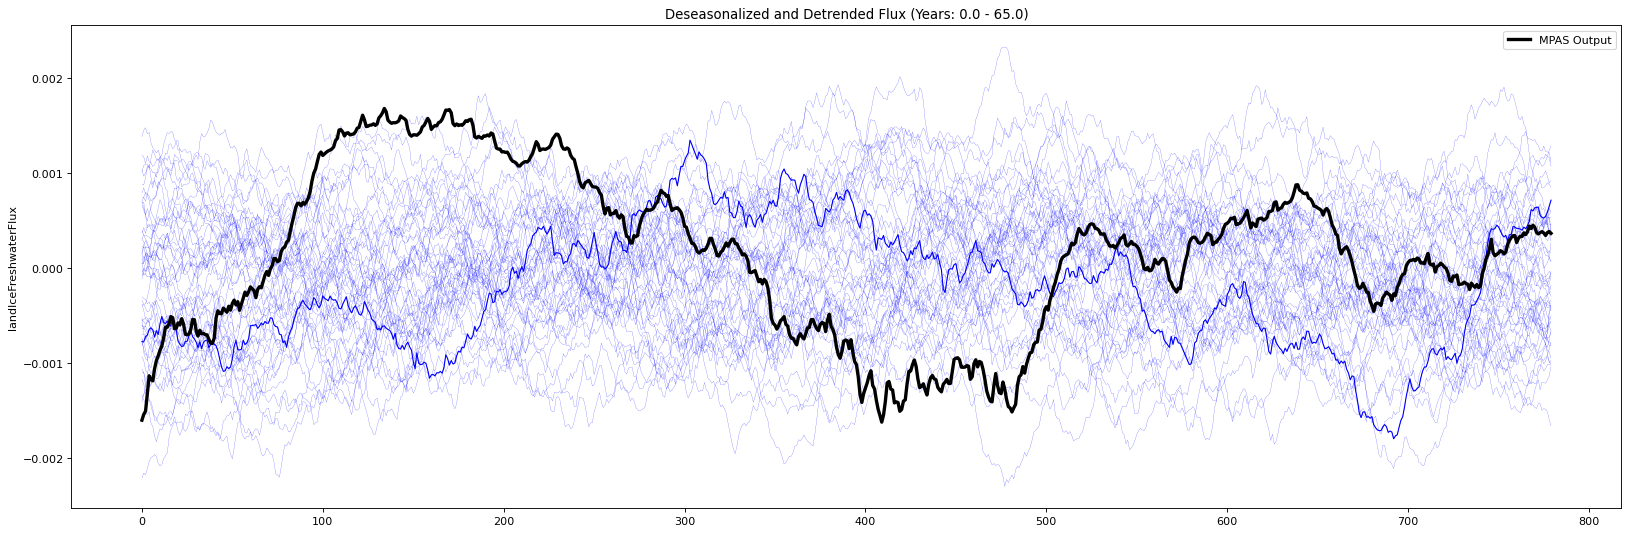

In [19]:
plt.figure(figsize=(25, 8), dpi=80)

for i in range(n_realizations):
    plt.plot(new_fl[i,t1:tf,0],'b', linewidth=0.15)

#plt.plot(new_fl[0,t1:tf,0],'b', linewidth=1, label='Randomized Output')
#plt.plot(new_fl[1,t1:tf,0],'b', linewidth=1)
plt.plot(new_fl[4,t1:tf,0],'b', linewidth=1)
plt.plot(fluxpcs[t1:tf,0],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f})'.format((spinuptime+t1)/12,(spinuptime+tf)/12))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

In [22]:
import gc

In [20]:
################################################################################
################################################################################
################################################################################
####-------- REDEFINE THIS SECTION TO LOOP THROUGH ALL REALIZATIONS --------####

fluxpcs_new = xr.DataArray(new_fl[4], coords=fluxpcs.coords, dims = fluxpcs.dims, attrs=fluxpcs.attrs)

In [64]:
### reconstruct field: code optimized


# Store the input data in an instance variable.
if flux_clean.ndim < 2:
    raise ValueError('the input data set must be at least two dimensional')
_data = flux_clean.to_numpy().copy()
# Check if the input is a masked array. If so fill it with NaN.
try:
    _data = _data.filled(fill_value=np.nan)
    _filled = True
except AttributeError:
    _filled = False
# Store information about the shape/size of the input data.
_records = _data.shape[0]
_originalshape = _data.shape[1:]
channels = np.product(_originalshape)
# Remove the time mean of the input data unless explicitly told
# not to by the "center" argument.
# Reshape to two dimensions (time, space) creating the design matrix.
_data = _data.reshape([_records, channels])
# Find the indices of values that are not missing in one row. All the
# rows will have missing values in the same places provided the
# array was centered. If it wasn't then it is possible that some
# missing values will be missed and the singular value decomposition
# will produce not a number for everything.
if not _valid_nan(_data):
    raise ValueError('missing values detected in different '
                     'locations at different times')
nonMissingIndex = np.where(np.logical_not(np.isnan(_data[0])))[0]
# Remove missing values from the design matrix.
dataNoMissing = _data[:, nonMissingIndex]
if dataNoMissing.size == 0:
    raise ValueError('all input data is missing')
# Compute the singular value decomposition of the design matrix.
try:
    A, Lh, E = np.linalg.svd(dataNoMissing, full_matrices=False)
except (np.linalg.LinAlgError, ValueError):
    raise ValueError('error encountered in SVD, check that missing '
                     'values are in the same places at each time and '
                     'that all the values are not missing')
# Singular values are the square-root of the eigenvalues of the
# covariance matrix. Construct the eigenvalues appropriately and
# normalize by N-ddof where N is the number of observations. This
# corresponds to the eigenvalues of the normalized covariance matrix.
_ddof = 1 # defaults to 1
normfactor = float(_records - _ddof)
_L = Lh * Lh / normfactor
# Store the number of eigenvalues (and hence EOFs) that were actually
# computed.
neofs = len(_L)
# Re-introduce missing values into the eigenvectors in the same places
# as they exist in the input maps. Create an array of not-a-numbers
# and then introduce data values where required. We have to use the
# astype method to ensure the eigenvectors are the same type as the
# input dataset since multiplication by np.NaN will promote to 64-bit.
_flatE = np.ones([neofs, channels],
                      dtype=_data.dtype) * np.NaN
_flatE = _flatE.astype(_data.dtype)
_flatE[:, nonMissingIndex] = E
# Remove the scaling on the principal component time-series that is
# implicitily introduced by using SVD instead of eigen-decomposition.
# The PCs may be re-scaled later if required.
#_P = A * Lh
_P = fluxpcs_new.to_numpy()


########################


if isinstance(neofs, collections.abc.Iterable):
    modes = [m - 1 for m in neofs]
else:
    modes = slice(0, neofs)
# Project principal components onto the EOFs to compute the
# reconstructed field.
rval = np.dot(_P[:, modes], _flatE[modes])
# Reshape the reconstructed field so it has the same shape as the
# input data set.
rval = rval.reshape((_records,) + _originalshape)

# Return the reconstructed field.
if _filled:
    rval = ma.array(rval, mask=np.where(np.isnan(rval), True, False)) 

SyntaxError: 'return' outside function (2156757712.py, line 85)

In [73]:
flux_clean.shape

(1560, 601, 601)

In [77]:
reconstr_full = xr.DataArray(rval, dims = flux_clean.dims, coords = flux_clean.coords, attrs = flux_clean.attrs)
reconstr_full = reconstr_full.rename('timeMonthly_avg_landIceFreshwaterFlux')

In [78]:
reconstr_full_ts = reconstr_full.sum(['y','x'])

In [63]:
import collections

In [47]:
def _valid_nan(in_array):
        inan = np.isnan(in_array)
        return (inan.any(axis=0) == inan.all(axis=0)).all()

In [23]:
np_reconstr_array = np.empty(data.timeMonthly_avg_landIceFreshwaterFlux.shape)
np_reconstr_array[:] = 0

reconstr_array = xr.DataArray(np_reconstr_array, coords=data.timeMonthly_avg_landIceFreshwaterFlux.coords, dims = data.timeMonthly_avg_landIceFreshwaterFlux.dims, attrs=data.timeMonthly_avg_landIceFreshwaterFlux.attrs)

for m in range(10):
    reconstr_mode_m = fluxpcs_new[:,m]*fluxeofs[m,:,:]
    reconstr_array = reconstr_array + reconstr_mode_m
    #reconstr_mode_flux = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(reconstr_mode_m)))
    #reconstr_flux = xr.merge([reconstr_flux, reconstr_mode_flux], compat='no_conflicts')
    del reconstr_mode_m
    print('added mode: {}'.format(m))
    gc.collect()

added mode: 0
added mode: 1
added mode: 2
added mode: 3
added mode: 4
added mode: 5
added mode: 6
added mode: 7
added mode: 8
added mode: 9


In [1]:
reconstr_array_ts = reconstr_array.sum(['y','x'])

NameError: name 'reconstr_array' is not defined

In [ ]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Flux trend in time: Contourf animation

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(15,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# vmin=-0.000005
# vmax=0.0008

# Plot the initial frame.
# vmin = np.min(flux), vmax = np.max(flux) obtained manually. These should be modified to skip ocean flux values
cax = reconstr_array[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm',
                       cbar_kwargs={'extend':'neither'})

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(reconstr_array[frame,:,:].values.flatten())
    ax.set_title("time = " + str(flux.coords['time'].values[frame])[:7])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=500,       # Could also be iterable or list
    interval=100     # ms between frames
)


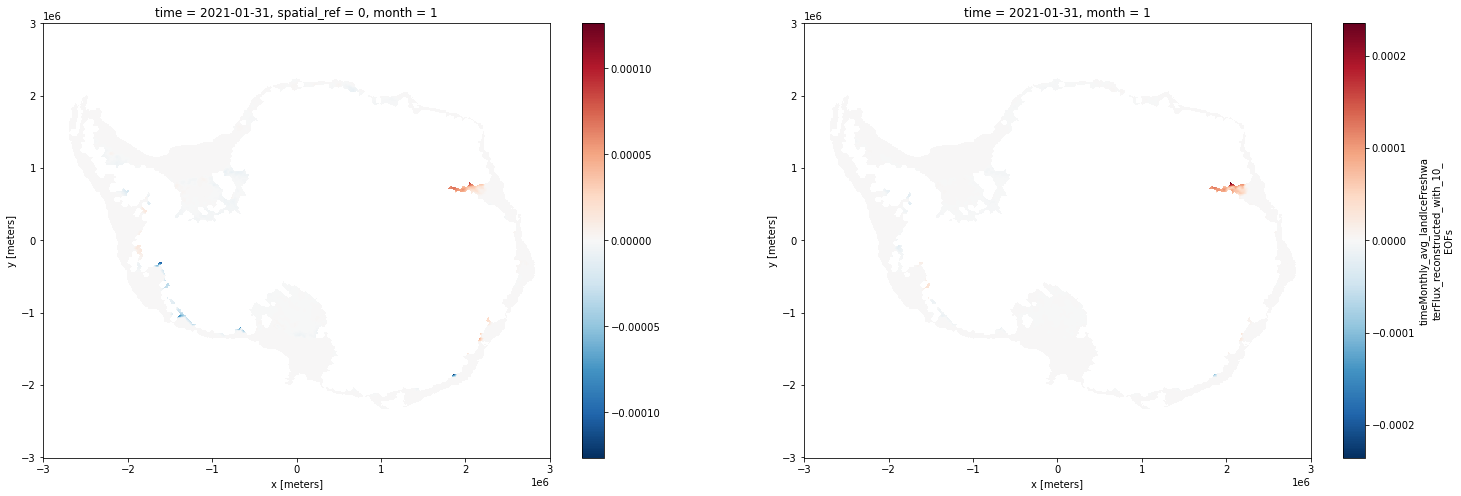

In [25]:
plt.figure(figsize=(25,8))
plt.subplot(121)
reconstr_array[0].plot()
plt.subplot(122)
fluxrec[0].plot()

In [ ]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Flux trend in time: Contourf animation

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(15,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# vmin=-0.000005
# vmax=0.0008

# Plot the initial frame.
# vmin = np.min(flux), vmax = np.max(flux) obtained manually. These should be modified to skip ocean flux values
plt.subplot(121)
cax1 = fluxrec[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm',
                       cbar_kwargs={'extend':'neither'})
plt.subplot(122)
cax2 = reconstr_array[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm',
                       cbar_kwargs={'extend':'neither'})


# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax1.set_array(fluxrec[frame,:,:].values.flatten())
    cax2.set_array(reconstr_array[frame,:,:].values.flatten())
    #ax.set_title("time = " + str(flux.coords['time'].values[frame])[:7])

# Finally, we use the animation module to create the animation.
ani2 = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=500,       # Could also be iterable or list
    interval=100     # ms between frames
)

In [80]:
fluxrec.rio.write_crs("epsg:3031",inplace=True);
reconstr_array.rio.write_crs("epsg:3031",inplace=True);

orig_amery = flux_clean.rio.clip(icems.loc[[34],'geometry'].apply(mapping),icems.crs,drop=False)
rec_amery = reconstr_full.rio.clip(icems.loc[[34],'geometry'].apply(mapping),icems.crs,drop=False)

In [178]:
orig_ameryn = orig_amery.dropna('time',how='all')
orig_ameryn = orig_ameryn.dropna('y',how='all')
orig_ameryn = orig_ameryn.dropna('x',how='all')

rec_ameryn = rec_amery.dropna('time',how='all')
rec_ameryn = rec_ameryn.dropna('y',how='all')
rec_ameryn = rec_ameryn.dropna('x',how='all')

In [179]:
orig_ameryn = orig_ameryn.drop("month")
rec_ameryn = rec_ameryn.drop("month")

In [82]:
orig_ameryn_ts = orig_ameryn.sum(['y','x'])
rec_ameryn_ts = rec_ameryn.sum(['y','x'])

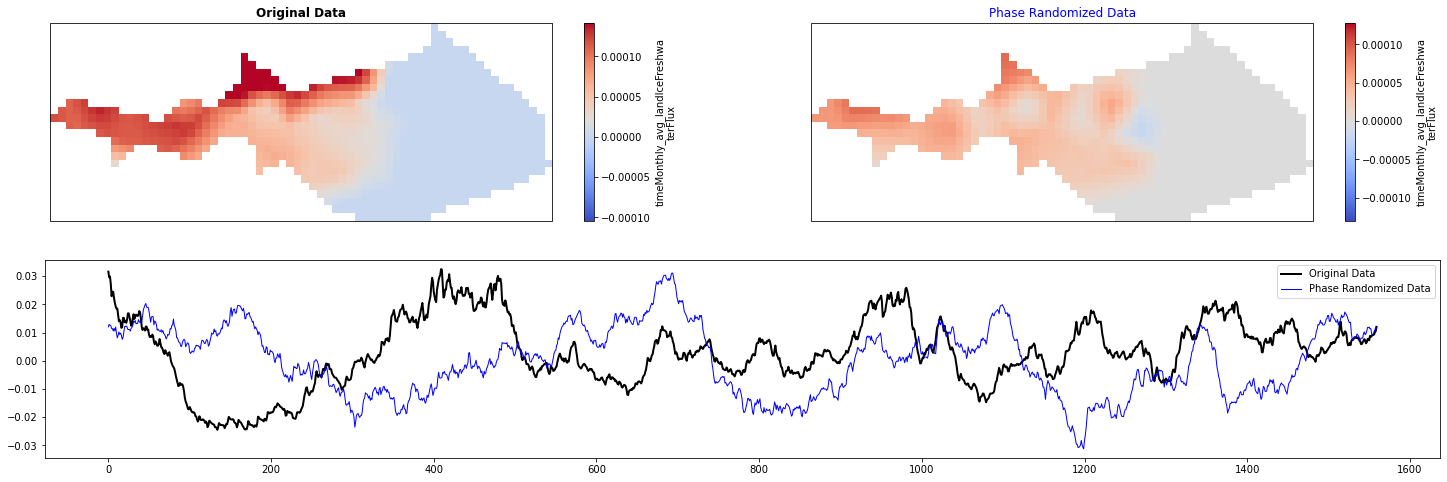

In [293]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Flux trend in time: Contourf animation

# Get a handle on the figure and the axes
fig, axs = plt.subplots(2,2,figsize=(25,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# vmin=-0.000005
# vmax=0.0008

#axs[0, 0].set_title('Axis [0, 0]')

# Plot the initial frame.
# vmin = np.min(flux), vmax = np.max(flux) obtained manually. These should be modified to skip ocean flux values
plt.subplot(221)
cax1 = orig_ameryn[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = np.max(orig_ameryn)/2, vmin = np.min(orig_ameryn)/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Original Data: " + str(orig_ameryn.coords['time'].values[frame])[:7])
plt.title("Original Data", color= 'black', fontweight='bold')


plt.subplot(222)
cax2 = rec_ameryn[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = np.max(rec_ameryn)/2, vmin = np.min(rec_ameryn)/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Phase Randomized Data: " + str(rec_ameryn.coords['time'].values[frame])[:7])
plt.title("Phase Randomized Data", color= 'blue')

plt.subplot(2,2,(3,4))
cax3, = plt.plot(orig_ameryn_ts, 'k', linewidth=2, label = 'Original Data')
cax4, = plt.plot(rec_ameryn_ts,  'b', linewidth=1, label = 'Phase Randomized Data')

plt.legend()

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax1.set_array(orig_ameryn[frame,:,:].values.flatten())
    #ax.set_title('Original Simulation')
    cax2.set_array(rec_ameryn[frame,:,:].values.flatten())
    #ax.set_title("time = " + str(rec_ameryn.coords['time'].values[frame])[:7])
    #fig.set_title('Phase Randomized Emulation')
    #cax3.set_array(orig_ameryn_ts[frame-2:frame+2].values.flatten())
    #cax3.set_array(orig_ameryn[frame].values.flatten())
    cax3.set_ydata(orig_ameryn_ts[:frame]) # ANIMATED
    cax3.set_xdata(range(frame)) # ANIMATED
    cax3.set_marker('.')
    cax3.set_markersize(0.25)
    cax4.set_ydata(rec_ameryn_ts[:frame])
    cax4.set_xdata(range(frame))
    cax4.set_marker('.')
    cax4.set_markersize(0.25)

# Finally, we use the animation module to create the animation.
ani2 = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(orig_ameryn_ts),  # Could also be iterable or list
    interval=100     # ms between frames
)

In [294]:
#HTML(ani2.to_jshtml())
ani2.save(inDirName+figures_folderpath+'Amery_comparison.mp4')

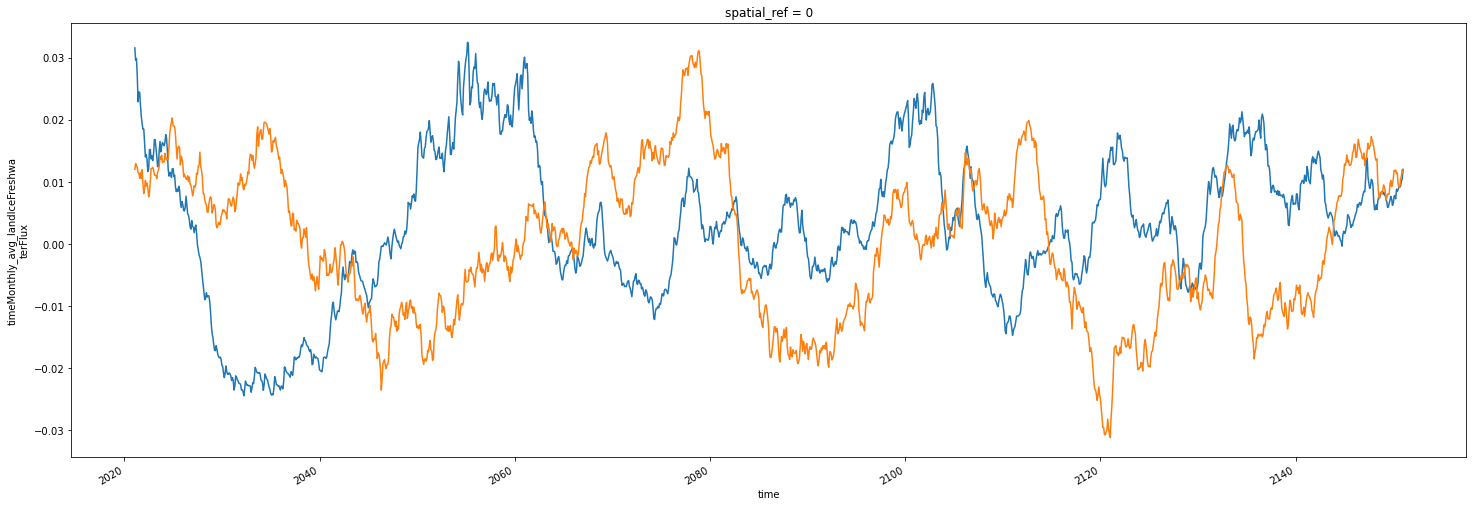

In [84]:
plt.figure(figsize=(25,8))
orig_ameryn_ts.plot()
rec_ameryn_ts.plot()

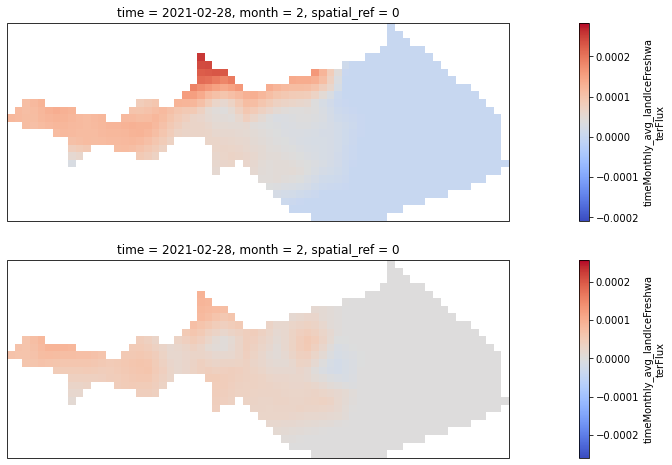

In [167]:
# create a figure and axes
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(25,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# set up the subplots as needed


cax = orig_ameryn[1,:,:].plot(ax = ax1, add_colorbar=True,
                       cmap='coolwarm', vmax = np.max(orig_ameryn), vmin = np.min(orig_ameryn),
                       cbar_kwargs={'extend':'neither'})

cax2 = rec_ameryn[1,:,:].plot(ax = ax2, add_colorbar=True,
                       cmap='coolwarm', vmax = np.max(rec_ameryn), vmin = np.min(rec_ameryn),
                       cbar_kwargs={'extend':'neither'})

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(orig_ameryn[frame,:,:].values.flatten())
    #ax1.set_title("time = " + str(flxn.coords['time'].values[frame])[:7])
    ax1.set_title('Original Data')
    cax2.set_array(rec_ameryn[frame,:,:].values.flatten())
    #ax2.set_title("time = " + str(flxn_k2.coords['time'].values[frame])[:7])
    ax2.set_title('Phase Randomized Data')

# Finally, we use the animation module to create the animation.
ani3 = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=500,       # Could also be iterable or list
    interval=100     # ms between frames
)

In [ ]:
HTML(ani3.to_jshtml())

In [ ]:
reconstr_array = reconstr_array.to_numpy()
reconstr_array = xr.DataArray(reconstr_array, coords = fluxrec.coords, dims = fluxrec.dims, attrs = fluxrec.attrs)

In [ ]:
reconstr_array = reconstr_array.rename('timeMonthly_avg_landIceFreshwaterFlux')

In [ ]:
# View animation in browser / save to file
HTML(ani.to_jshtml())
# ani.save(inDirName+figures_folderpath+'AIS_flux.mp4')

In [ ]:
plt.figure(figsize=(25,8))
rec_ts.plot()
reconstr_array_ts.plot()

In [ ]:
rec_new = fluxsolver.reconstructedField(fluxsolver.neofs)

In [ ]:
rec_new_ts = rec_new.sum(['y','x'])

In [ ]:
plt.figure(figsize=(25, 8), dpi=80)
flux_demeaned_ts.plot()
rec_new_ts.plot()